<a id='another_cell'></a>

# Contents 
#### <a href='#Data'>Data</a>

#### <a href='#Feature engineering'>Feature engineering</a>

#### <a href='#Exploratory analysis'>Exploratory analysis</a>

#### <a href='#Regression'>Modeling</a>

#### <a href='#Model tuning'>Model tuning</a>

#### <a href='#prediction'>Prediction on Test Set</a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

<a id='Data'></a>

# Data

First get a sense of what the dataset looks like (shape, head, data types of each columns)

In [2]:
# training data
df = pd.read_csv('train.csv')
print df.shape
print df.head()
print df.dtypes

(10886, 12)
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual   

Check if there is missing values

In [3]:
print df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


Skewness of numerical variables

In [3]:
df[df.columns[5:]].skew()

temp          0.003691
atemp        -0.102560
humidity     -0.086335
windspeed     0.588767
casual        2.495748
registered    1.524805
count         1.242066
dtype: float64

Change 'datetime' to Datetime object 

Also see time span this dataset covers

In [3]:
datetime = pd.to_datetime(df.datetime)
print datetime.max(),datetime.min()

2012-12-19 23:00:00 2011-01-01 00:00:00


See counts of uniques values for each categorical feature, and check if distributions of those features follow common sense. For example, for feature 'season', there should be only 4 unique values and counts of each season should be around the same. 

Also plot correlation of numerical features, to see data interaction. 

In order to predict 'count', 'casual' and 'registered' need to be removed. 

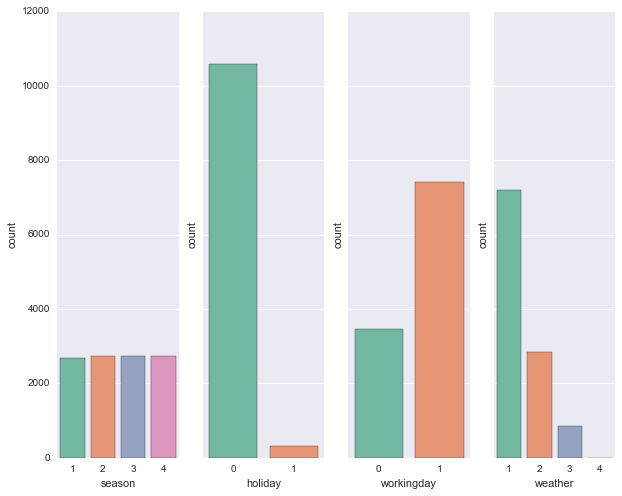

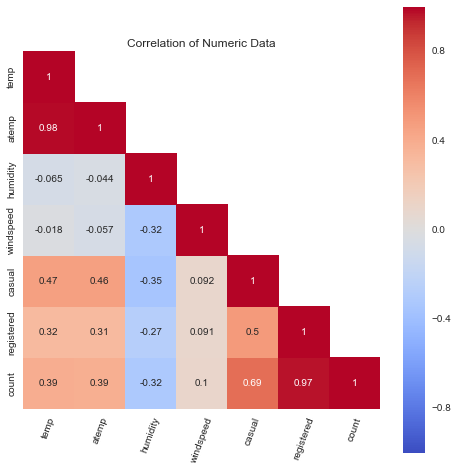

In [5]:
# countplot 
fig, ax = plt.subplots(nrows=1,ncols=4,sharey='row',figsize=(10, 8))
seaborn.countplot(x='season',palette="Set2",data=df,ax=ax[0])
seaborn.countplot(x='holiday',palette="Set2",data=df,ax=ax[1])
seaborn.countplot(x='workingday',palette="Set2",data=df,ax=ax[2])
seaborn.countplot(x='weather',palette="Set2",data=df,ax=ax[3])

# heatmap for correlations 
corr = df[df.columns[5:]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,k=1)] = True
with seaborn.axes_style("white"):
    plt.figure(figsize=(8,8))
    ax = seaborn.heatmap(corr,mask=mask,cmap='coolwarm', vmin = -1, vmax=1, square=True,annot=True)
    ax.set_xticklabels(df.columns[5:], rotation=70)
    plt.title('Correlation of Numeric Data')

Distribution of response variable 'count'

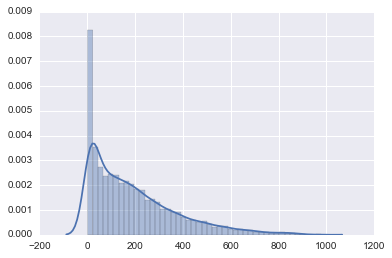

In [6]:
seaborn.distplot(df['count'].values)

Transform the values to make them distributed more normally 

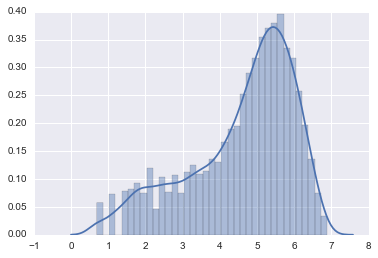

In [7]:
seaborn.distplot(np.log1p(df['count'].values))

<a id='Feature engineering'></a>

# Feature engineering 

Extract month, date, and hour from 'datetime' as new features

In [4]:
df['Date'] = datetime.dt.date
df['Month'] = datetime.dt.month
df['Hour'] = datetime.dt.hour

In [5]:
# get a copy of dataframe for exploratory analysis later
df_explore = df

Change dtype to string, so we can get dummy variables easily

In [6]:
cat_col = df.columns[1:5].values.tolist() + df.columns[-2:].values.tolist()

for i in cat_col:
    df[i] = df[i].astype('str')

Get dummy variables and drop columns ['datetime','count','casual','registered','Date']

In [7]:
count = df['count'] # get response variable

df = pd.concat([df,pd.get_dummies(df[cat_col])],axis=1).drop(cat_col+['datetime','count','casual','registered','Date'],axis=1)

In [8]:
# shape of new df
df.shape

(10886, 52)

<a id='Exploratory analysis'></a>

# Exploratory analysis

In this section I generated some plots that deliver insights of data. 

In [16]:
df_explore['Hour'] = df_explore.Hour.astype('int')
df_explore['Month'] = df_explore.Month.astype('int')

In [17]:
cm = plt.get_cmap('RdYlBu_r')
colors = [cm(x) for x in [0.25,0.9,0.7,0.1]]

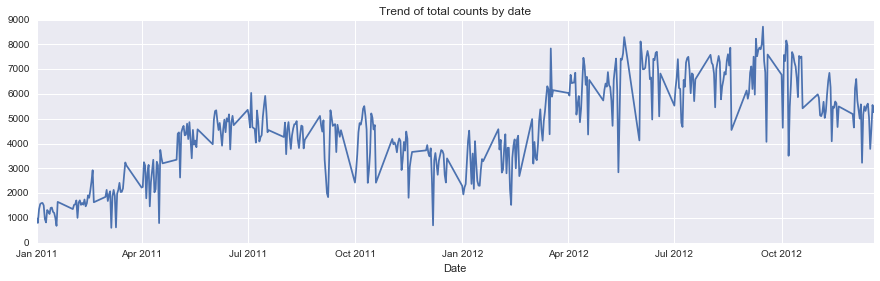

In [18]:
plt.figure(figsize = (15,4))
plt.title('Trend of total counts by date')
df_explore.groupby('Date')['count'].sum().plot()

From this plot, we can see that there is an increasing trend of demand, as demand in 2012 is higher than demand in 2011. 

And from April/May to Oct is peak season for bike rental. I am going to further examine monthly and hourly data.

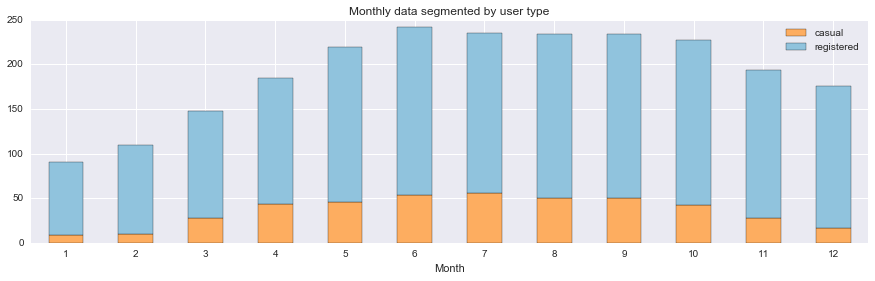

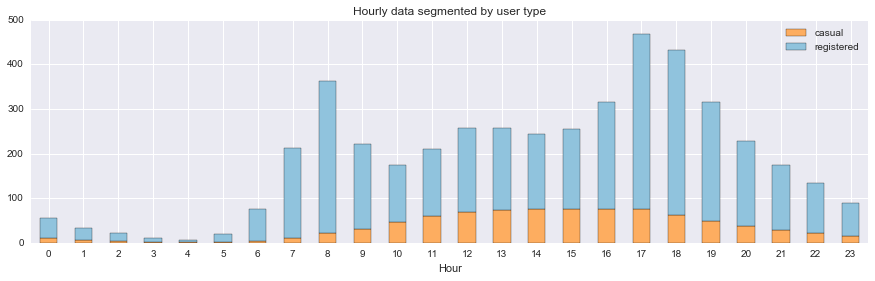

In [19]:
df_explore.groupby('Month').mean()[['casual','registered']].plot(kind='bar',stacked=True,figsize=(15,4),
                                                                 color=(colors[2],colors[0]),
                                                                 title='Monthly data segmented by user type',
                                                                 rot=0)
df_explore.groupby('Hour').mean()[['casual','registered']].plot(kind='bar',stacked=True,figsize=(15,4),
                                                                 color=(colors[2],colors[0]),
                                                                 title='Hourly data segmented by user type',
                                                                 rot=0)

By looking at average monthly and hourly data, we can see that June is the peak month for bike rental. 

And there are two peaks daily, 8 am and 5 to 6 pm. This pattern is more obvious for registered user.

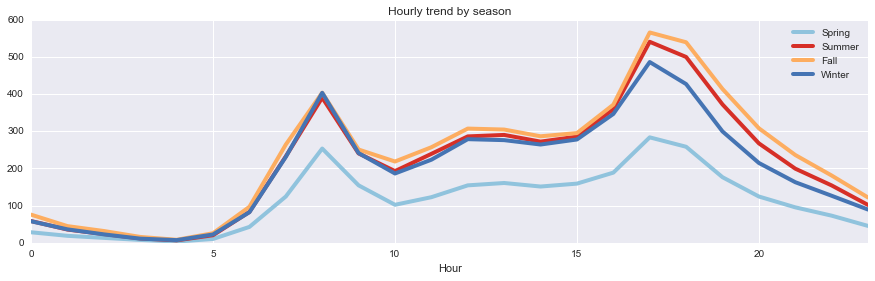

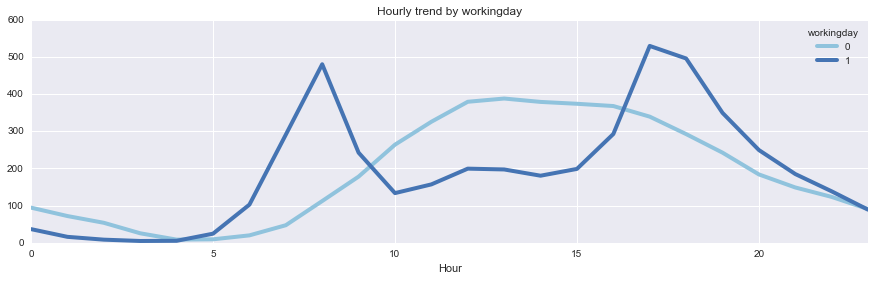

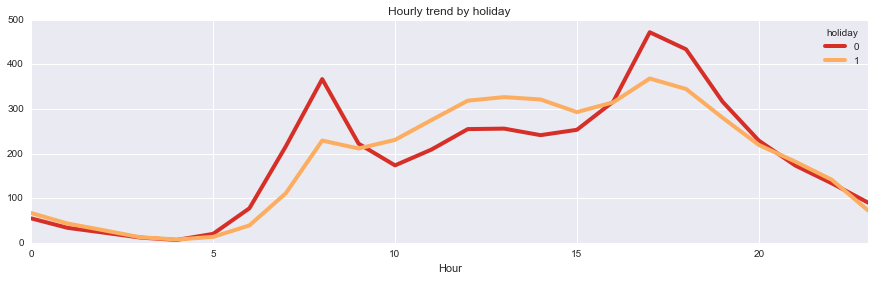

In [20]:
df_explore.groupby(['Hour','season'])['count'].mean().unstack().plot(figsize=(15,4),color=colors,
                                                                     title='Hourly trend by season',linewidth = 4)
L = plt.legend(fontsize = 'medium')
L.get_texts()[0].set_text('Spring')
L.get_texts()[1].set_text('Summer')
L.get_texts()[2].set_text('Fall')
L.get_texts()[3].set_text('Winter')

df_explore.groupby(['Hour','workingday'])['count'].mean().unstack().plot(figsize=(15,4),color=(colors[0],colors[-1]),
                                                                     title='Hourly trend by workingday',linewidth = 4)

df_explore.groupby(['Hour','holiday'])['count'].mean().unstack().plot(figsize=(15,4),color=(colors[1],colors[2]),
                                                                     title='Hourly trend by holiday',linewidth = 4)

From graphs above, we can see that daily peaks (8 am and 5 to 6 pm) are very obvious on non-holiday and working day, which might suggest that majority of customers are people who commute to work. 

We can also see that summer and fall are two seasons that have larger rental demand.

<a id='Regression'></a>

# Regression

In [9]:
from sklearn.model_selection import train_test_split
X = df.values
y = count.values

#split training data into training and validation set 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=19)

In [10]:
# define evaluation metric 
def eval(y_true, y_pred):
    a = np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)
    return np.sqrt(a)  

In [11]:
# transform response variable
y_train_transformed = np.log1p(y_train)

Regularized regression 

In [13]:
from sklearn import linear_model

lasso = linear_model.Lasso()

lasso.fit(X_train,y_train_transformed)

y_pred_lasso = lasso.predict(X_val)

In [25]:
eval(y_val,np.expm1(y_pred_lasso))

1.2302635460671465

In [26]:
ridge = linear_model.Ridge()

ridge.fit(X_train,y_train_transformed)

y_pred_ridge = ridge.predict(X_val)

In [27]:
eval(y_val,np.expm1(y_pred_ridge))

0.63950884657467366

Ensemble model - Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train,y_train_transformed)

y_pred_rf = rf.predict(X_val)

In [29]:
eval(y_val,np.expm1(y_pred_rf))

0.42686416604662586

<a id='Model tuning'></a>

# Model tuning 

To save time, I just use a very simple method to tune models by trying different sets of hyperparameters. 

Lasso 

Optimal alpha - 0.0011, with loss 0.6388

min loss with hyperparameter:  0.638844226098 0.00111111111111


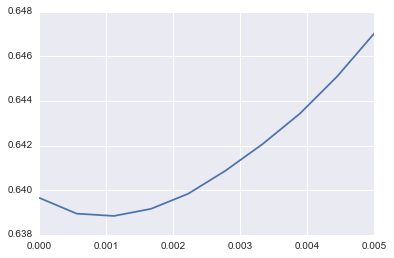

In [24]:

# try different sets for alpha 

#alpha_lasso = np.linspace(0,2,20)
#alpha_lasso = np.linspace(0,0.1,20)
alpha_lasso = np.linspace(0,0.005,10)

lasso_eval = []

for i in alpha_lasso:
    model = linear_model.Lasso(alpha=i)
    model.fit(X_train,y_train_transformed)
    y_pred = model.predict(X_val)
    lasso_eval.append(eval(y_val,np.expm1(y_pred)))

print 'min loss with hyperparameter: ', np.min(lasso_eval),alpha_lasso[np.argmin(lasso_eval)]
plt.plot(alpha_lasso,lasso_eval)

Ridge

Optimal alpha - 7.36, with loss 0.639092

min loss with hyperparameter:  0.639092033758 7.36842105263


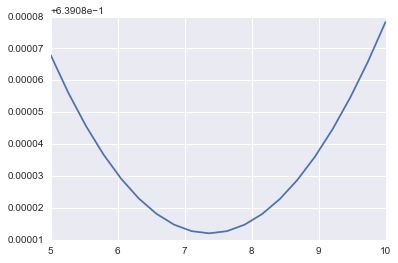

In [25]:
# try different sets for alpha

#alpha_ridge = np.linspace(0,2,20)
#alpha_ridge = np.linspace(2,5,20)
alpha_ridge = np.linspace(5,10,20)

ridge_eval = []

for i in alpha_ridge:
    model = linear_model.Ridge(alpha=i)
    model.fit(X_train,y_train_transformed)
    y_pred = model.predict(X_val)
    ridge_eval.append(eval(y_val,np.expm1(y_pred)))
    
print 'min loss with hyperparameter: ', np.min(ridge_eval),alpha_ridge[np.argmin(ridge_eval)]
plt.plot(alpha_ridge,ridge_eval)

Random Forest 

Optimal number of estimators - 300, with validation loss 0.4048

min loss with hyperparameter:  0.404885276588 300


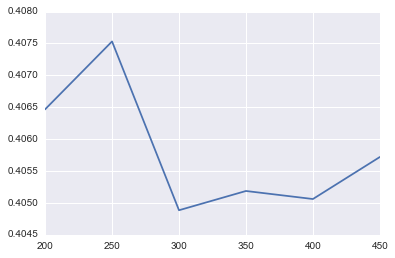

In [26]:
#n = range(10,200,20)
n = range(200,500,50)

rf_eval =[]

for i in n:
    model = RandomForestRegressor(n_estimators=i)
    model.fit(X_train,y_train_transformed)
    y_pred = model.predict(X_val)
    rf_eval.append(eval(y_val,np.expm1(y_pred)))

print 'min loss with hyperparameter: ', np.min(rf_eval),n[np.argmin(rf_eval)]
plt.plot(n,rf_eval)

<a id='prediction'></a>

# Prediction on test set

In [11]:
# test data
df_test = pd.read_csv('test.csv')
print df_test.shape
print df_test.head()
print df_test.dtypes
print df_test.isnull().sum()

(6493, 9)
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014  
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: in

In [12]:
# process test set like what I did to training set 

datetime_test = pd.to_datetime(df_test.datetime)

df_test['Month'] = datetime_test.dt.month
df_test['Hour'] = datetime_test.dt.hour

cat_col_test = df_test.columns[1:5].values.tolist() + df_test.columns[-2:].values.tolist()

for i in cat_col_test:
    df_test[i] = df_test[i].astype('str')

df_test = pd.concat([df_test,pd.get_dummies(df_test[cat_col_test])],axis=1).drop(cat_col+['datetime'],axis=1)

In [13]:
# make sure training and test set have the same number of features
print df.shape, df_test.shape

(10886, 52) (6493, 52)


In [18]:
# train random forest model on all training data

y_transformed = np.log1p(y)

best_rf = RandomForestRegressor(n_estimators=300)
best_rf.fit(X,y_transformed)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
# predict using the best model 

X_test = df_test.values

y_test = np.expm1(best_rf.predict(X_test))

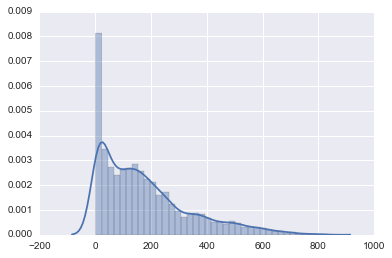

In [23]:
seaborn.distplot(y_test)

In [41]:
# save predictions 
result = pd.DataFrame({'datetime':datetime_test,'count':y_test})
result = result[['datetime','count']]
result.to_csv('predicted_result.csv',index=False)